BLOK 0

In [ ]:
!pip install numpy==1.24.4
!pip install pandas scikit-learn matplotlib seaborn statsmodels
!pip install pmdarima

# Blok 1

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc 


plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# --- Memuat Dataset ---
# PETUNJUK:
# 1. Klik ikon folder di sidebar kiri Google Colab.
# 2. Klik ikon "Upload to session storage" (ikon file dengan panah ke atas).
# 3. Pilih dan unggah file 'flights.csv' Anda.
# 4. Pastikan nama file di bawah ini ('flights.csv') sesuai dengan nama file yang Anda unggah.

file_name = 'flights.csv' # Nama file yang diunggah ke session storage Colab

try:
    print(f"Mencoba memuat dataset {file_name} dari session storage Colab...")
    # Menggunakan low_memory=False untuk menghindari peringatan tipe campuran pada dataset besar
    df_flights = pd.read_csv(file_name, low_memory=False)
    print("Dataset berhasil dimuat.")

    print("\n--- Informasi Dataset Awal ---")
    # Menggunakan verbose=True dan show_counts=True untuk detail maksimal
    df_flights.info(verbose=True, show_counts=True)

    print("\n--- Lima Baris Pertama Dataset ---")
    print(df_flights.head())

    print("\n--- Pemeriksaan Nilai Hilang (Top 10) ---")
    missing_values = df_flights.isnull().sum().sort_values(ascending=False)
    print(missing_values[missing_values > 0].head(10))

except FileNotFoundError:
    print(f"ERROR: File '{file_name}' tidak ditemukan di session storage Colab.")
    print("Pastikan Anda telah mengunggah file dengan nama yang benar menggunakan panel file di sebelah kiri.")
    df_flights = None
except Exception as e:
    print(f"Terjadi error saat memuat data: {e}")
    df_flights = None

print("\nSetup Blok 1 selesai.")

Mencoba memuat dataset flights.csv dari session storage Colab...
Dataset berhasil dimuat.

--- Informasi Dataset Awal ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 5819079 non-null  int64  
 1   MONTH                5819079 non-null  int64  
 2   DAY                  5819079 non-null  int64  
 3   DAY_OF_WEEK          5819079 non-null  int64  
 4   AIRLINE              5819079 non-null  object 
 5   FLIGHT_NUMBER        5819079 non-null  int64  
 6   TAIL_NUMBER          5804358 non-null  object 
 7   ORIGIN_AIRPORT       5819079 non-null  object 
 8   DESTINATION_AIRPORT  5819079 non-null  object 
 9   SCHEDULED_DEPARTURE  5819079 non-null  int64  
 10  DEPARTURE_TIME       5732926 non-null  float64
 11  DEPARTURE_DELAY      5732926 non-null  float64
 12  TAXI_OUT             5730032 non

# Blok 2

In [ ]:
# =============================================================================
# BLOK 2: PEMROSESAN DATA DENGAN SPARK (PYSPARK)
# =============================================================================
# Blok ini menggantikan simulasi Pandas dengan penggunaan nyata alat Big Data Spark.

# 1. Instal PySpark
# Cukup jalankan sekali per sesi.
!pip install pyspark -q

# 2. Impor pustaka yang diperlukan
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import gc

daily_flights_volume_ts = None # Inisialisasi hasil akhir

try:
    # 3. Inisialisasi SparkSession
    # Ini adalah titik masuk untuk semua fungsionalitas Spark.
    # 'local[*]' berarti Spark akan menggunakan semua core CPU yang tersedia di sesi Colab.
    print("Menginisialisasi SparkSession...")
    spark = SparkSession.builder.appName("FlightAnalysis").master("local[*]").getOrCreate()
    print("SparkSession berhasil dibuat.")

    # 4. Memuat Data Mentah ke Spark DataFrame
    file_name = 'flights.csv' # Pastikan file ini sudah diunggah
    print(f"Memuat {file_name} ke dalam Spark DataFrame...")

    # spark.read.csv lebih efisien untuk file besar daripada pandas.read_csv
    df_spark = spark.read.csv(file_name, header=True, inferSchema=True)

    # 5. Transformasi Data Menggunakan Spark (Replika Logika SQL/Pandas)
    print("Memproses data dengan Spark...")

    # a. Filter penerbangan yang tidak batal atau dialihkan (setara WHERE)
    df_filtered = df_spark.filter((F.col('CANCELLED') == 0) & (F.col('DIVERTED') == 0))

    # b. Buat kolom tanggal (setara PARSE_DATE / pd.to_datetime)
    df_with_date = df_filtered.withColumn('flight_date',
                                          F.to_date(F.concat_ws('-', 'YEAR', 'MONTH', 'DAY')))

    # c. Agregasi: Group by tanggal dan hitung jumlahnya (setara GROUP BY & COUNT)
    df_aggregated = df_with_date.groupBy('flight_date').count()

    # d. Ganti nama kolom 'count' menjadi 'num_flights' dan urutkan
    df_final_spark = df_aggregated.withColumnRenamed('count', 'num_flights').orderBy('flight_date')

    print("Pemrosesan Spark selesai.")

    # 6. Konversi Hasil Akhir (yang sudah kecil) ke Pandas DataFrame
    # Model SARIMA dan Matplotlib bekerja dengan Pandas, jadi kita konversi hasil akhirnya.
    print("Mengonversi hasil agregat Spark ke Pandas DataFrame...")
    daily_flights_volume_ts = df_final_spark.toPandas()

    # Set flight_date sebagai indeks untuk konsistensi dengan blok selanjutnya
    daily_flights_volume_ts['flight_date'] = pd.to_datetime(daily_flights_volume_ts['flight_date'])
    daily_flights_volume_ts = daily_flights_volume_ts.set_index('flight_date')

    print("\nProses dengan PySpark berhasil. Contoh data hasil agregasi:")
    print(daily_flights_volume_ts.head())

except Exception as e:
    print(f"Terjadi error selama proses Spark: {e}")

finally:
    # 7. Matikan SparkSession untuk membebaskan sumber daya
    if 'spark' in locals():
        print("Mematikan SparkSession.")
        spark.stop()
    gc.collect()

# Blok-blok selanjutnya (Blok 3, 4, 5, dst.) tidak perlu diubah sama sekali,
# karena mereka akan menerima DataFrame 'daily_flights_volume_ts' dalam format yang sama.

Menginisialisasi SparkSession...
SparkSession berhasil dibuat.
Memuat flights.csv ke dalam Spark DataFrame...
Memproses data dengan Spark...
Pemrosesan Spark selesai.
Mengonversi hasil agregat Spark ke Pandas DataFrame...

Proses dengan PySpark berhasil. Contoh data hasil agregasi:
             num_flights
flight_date             
2015-01-01         13464
2015-01-02         16456
2015-01-03         15050
2015-01-04         15887
2015-01-05         16074
Mematikan SparkSession.


# Blok 3

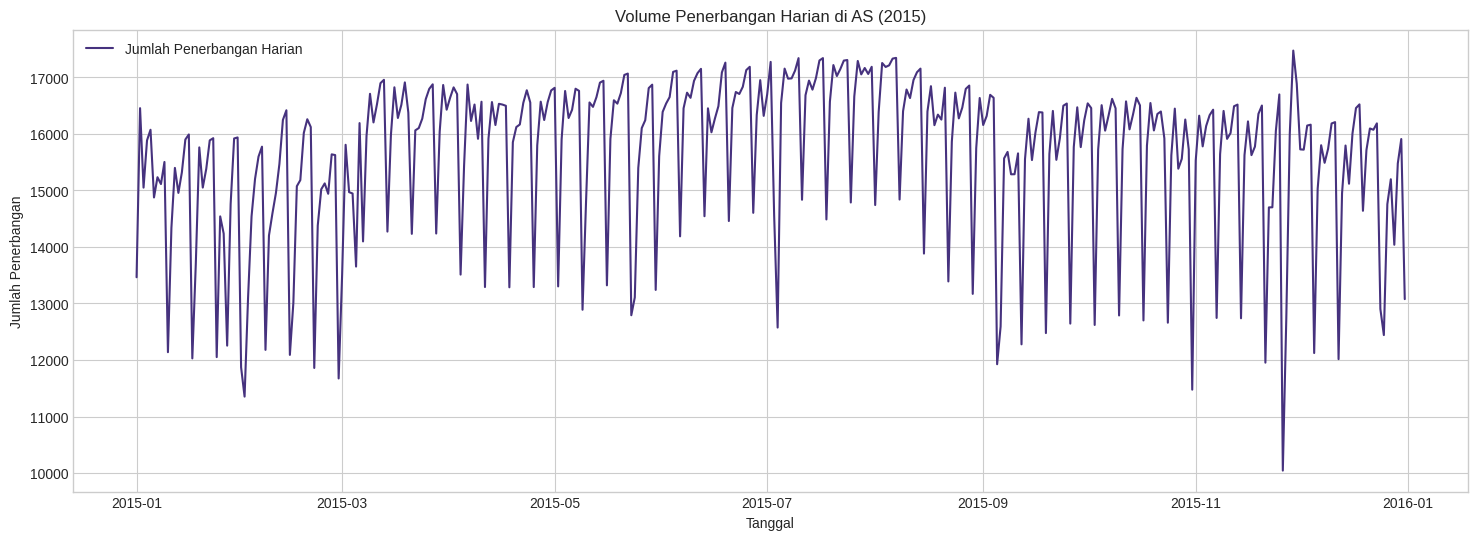

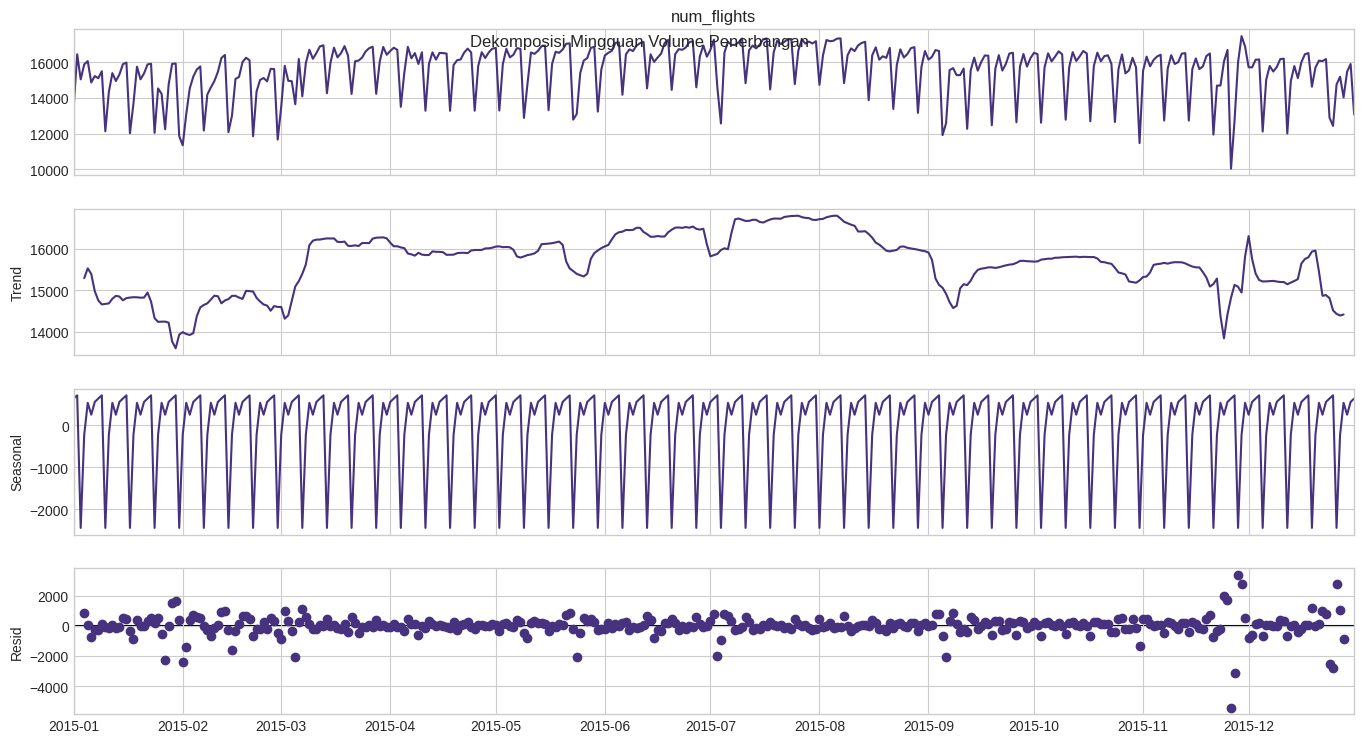

In [ ]:
if 'daily_flights_volume_ts' in locals() and daily_flights_volume_ts is not None:
    # Visualisasi Time Series
    plt.figure(figsize=(18, 6))
    plt.plot(daily_flights_volume_ts.index, daily_flights_volume_ts['num_flights'], label='Jumlah Penerbangan Harian')
    plt.title('Volume Penerbangan Harian di AS (2015)')
    plt.xlabel('Tanggal')
    plt.ylabel('Jumlah Penerbangan')
    plt.legend()
    plt.show()

    # Dekomposisi Time Series
    from statsmodels.tsa.seasonal import seasonal_decompose
    if len(daily_flights_volume_ts) >= 14:
        decomposition = seasonal_decompose(daily_flights_volume_ts['num_flights'], model='additive', period=7)
        fig = decomposition.plot()
        fig.set_size_inches(15, 8)
        plt.suptitle('Dekomposisi Mingguan Volume Penerbangan', y=0.92)
        plt.show()
    else:
        print("Tidak cukup data untuk melakukan dekomposisi.")

else:
    print("Data time series tidak tersedia untuk dianalisis.")

# Blok 4


--- Persiapan Data untuk Pemodelan Time Series ---
Ukuran data pelatihan: 304 observasi
Ukuran data pengujian: 61 observasi


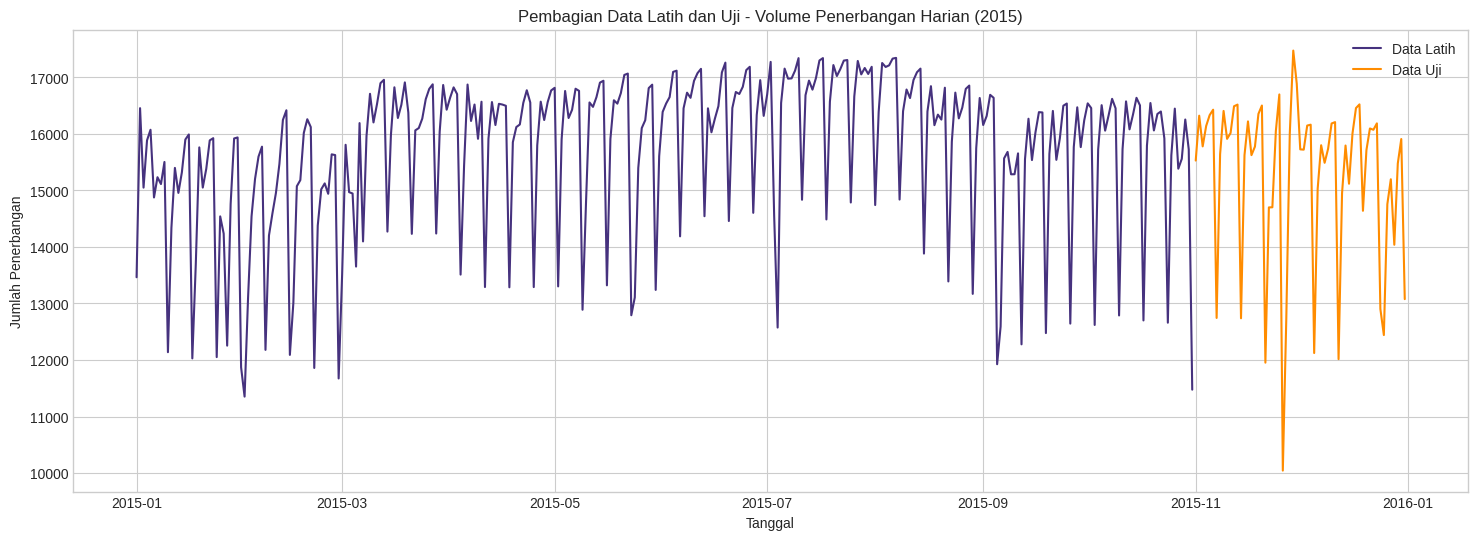

In [ ]:
if 'daily_flights_volume_ts' in locals() and not daily_flights_volume_ts.empty:
    print("\n--- Persiapan Data untuk Pemodelan Time Series ---")
    train_end_date = '2015-10-31'
    test_start_date = '2015-11-01'

    train_data = daily_flights_volume_ts[daily_flights_volume_ts.index <= train_end_date]
    test_data = daily_flights_volume_ts[daily_flights_volume_ts.index >= test_start_date]

    if train_data.empty or test_data.empty:
        print("Gagal membagi data. Data latih atau uji kosong.")
    else:
        print(f"Ukuran data pelatihan: {len(train_data)} observasi")
        print(f"Ukuran data pengujian: {len(test_data)} observasi")

        # Visualisasi pembagian data
        plt.figure(figsize=(18, 6))
        # PERBAIKAN: Menggunakan 'num_flights' (lowercase)
        plt.plot(train_data.index, train_data['num_flights'], label='Data Latih')
        plt.plot(test_data.index, test_data['num_flights'], label='Data Uji', color='darkorange')
        plt.title('Pembagian Data Latih dan Uji - Volume Penerbangan Harian (2015)')
        plt.xlabel('Tanggal')
        plt.ylabel('Jumlah Penerbangan')
        plt.legend()
        plt.show()
else:
    print("Data volume penerbangan harian tidak tersedia. Blok 4 dilewati.")

# Blok 5


--- Pemodelan Time Series dengan auto_arima (SARIMA) ---
Mencari parameter SARIMA terbaik (ini mungkin butuh beberapa menit)...


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '



Parameter SARIMA terbaik ditemukan:
  Order (p,d,q): (0, 1, 0)
  Seasonal Order (P,D,Q,m): (1, 0, 1, 7)

Melatih model SARIMA dengan parameter terbaik...
Model SARIMA berhasil dilatih.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


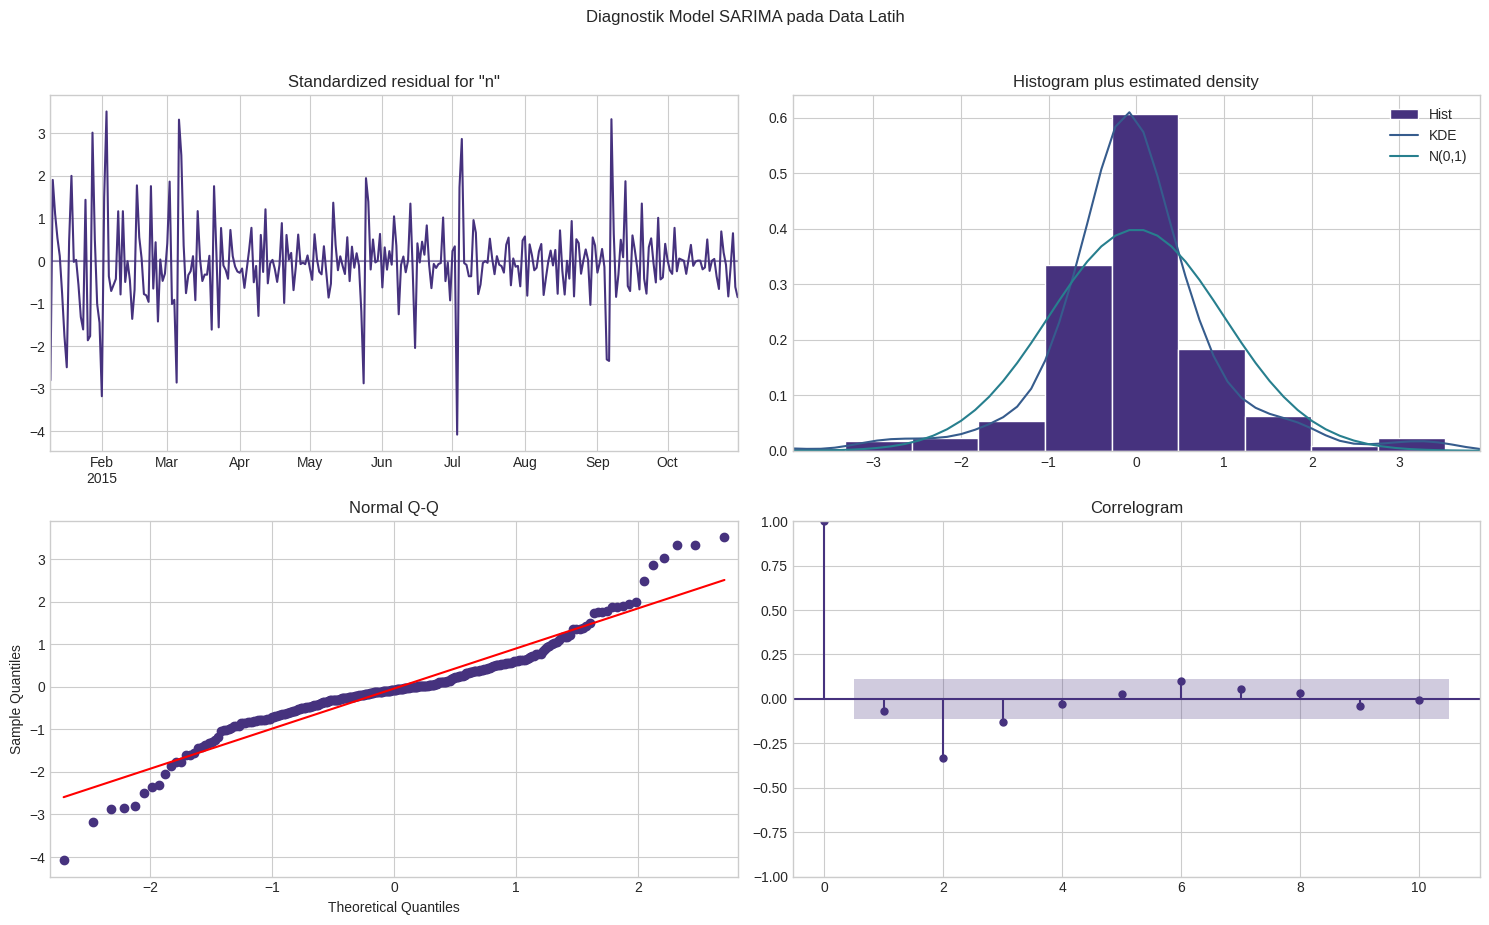

In [ ]:
# =============================================================================
# BLOK 5: PEMODELAN TIME SERIES DENGAN SARIMA
# =============================================================================
results_sarima = None # Inisialisasi di luar blok try

if 'train_data' in locals() and 'test_data' in locals() and not train_data.empty:
    print("\n--- Pemodelan Time Series dengan auto_arima (SARIMA) ---")

    # Impor pustaka yang diperlukan di sini
    import warnings
    from pmdarima import auto_arima
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from statsmodels.tools.sm_exceptions import ConvergenceWarning

    try:
        print("Mencari parameter SARIMA terbaik (ini mungkin butuh beberapa menit)...")

        # --- BLOK UNTUK MENYEMBUNYIKAN PERINGATAN ---
        # Menggunakan context manager untuk menekan peringatan hanya selama eksekusi auto_arima
        with warnings.catch_warnings():
            # Mengabaikan FutureWarning (seperti di screenshot) dan ConvergenceWarning
            warnings.simplefilter("ignore", category=FutureWarning)
            warnings.simplefilter("ignore", category=ConvergenceWarning)

            auto_model_sarima = auto_arima(
                train_data['num_flights'],
                seasonal=True, m=7,
                stepwise=True,
                suppress_warnings=True, # Ini juga membantu, tapi tidak selalu menangkap semuanya
                error_action='ignore',
                trace=False,
                n_jobs=-1
            )
        # --- Peringatan akan aktif kembali secara normal setelah blok 'with' selesai ---

        print("\nParameter SARIMA terbaik ditemukan:")
        print(f"  Order (p,d,q): {auto_model_sarima.order}")
        print(f"  Seasonal Order (P,D,Q,m): {auto_model_sarima.seasonal_order}")

        print("\nMelatih model SARIMA dengan parameter terbaik...")
        model_sarima = SARIMAX(
            train_data['num_flights'],
            order=auto_model_sarima.order,
            seasonal_order=auto_model_sarima.seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results_sarima = model_sarima.fit(disp=False)
        print("Model SARIMA berhasil dilatih.")

        # Tampilkan plot diagnostik
        results_sarima.plot_diagnostics(figsize=(15, 10))
        plt.suptitle("Diagnostik Model SARIMA pada Data Latih", y=0.92)
        plt.tight_layout(rect=[0, 0, 1, 0.9])
        plt.show()

    except ImportError:
        print("\nERROR: Pustaka 'pmdarima' atau 'statsmodels' tidak ditemukan.")
        print("Pastikan Anda telah menjalankan sel instalasi di awal dan me-RESTART RUNTIME.")
    except Exception as e:
        print(f"Terjadi error saat menjalankan auto_arima atau melatih model: {e}")

else:
    print("Data latih/uji belum siap atau kosong. Blok 5 dilewati.")

# Blok 6


--- Prediksi pada Data Uji dan Evaluasi Model SARIMA ---


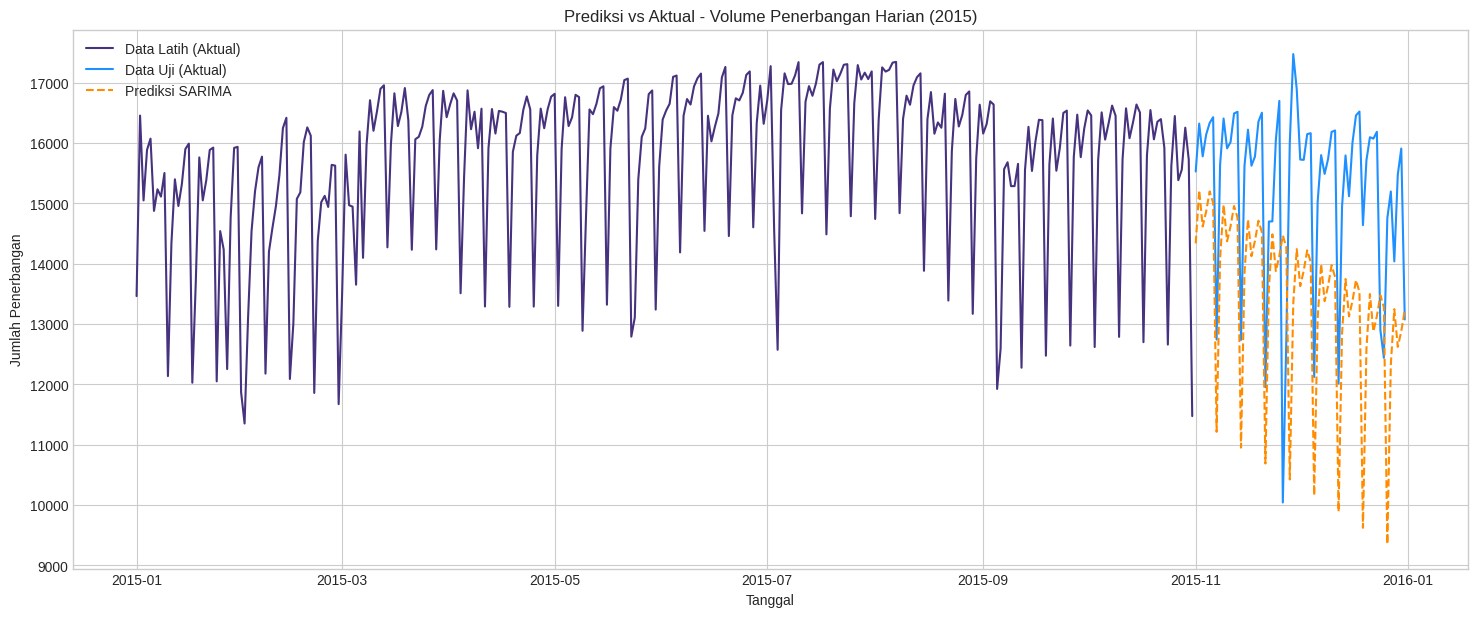


Metrik Evaluasi Model SARIMA pada Data Uji:
  Mean Absolute Error (MAE): 2096.81 penerbangan
  Root Mean Squared Error (RMSE): 2363.69 penerbangan
  Mean Absolute Percentage Error (MAPE): 13.83%


In [ ]:
if 'results_sarima' in locals() and results_sarima is not None and not test_data.empty:
    print("\n--- Prediksi pada Data Uji dan Evaluasi Model SARIMA ---")
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    predictions_sarima = results_sarima.get_prediction(start=test_data.index.min(), end=test_data.index.max())
    predicted_mean = predictions_sarima.predicted_mean

    plt.figure(figsize=(18, 7))
    # PERBAIKAN: Menggunakan 'num_flights'
    plt.plot(train_data['num_flights'], label='Data Latih (Aktual)')
    plt.plot(test_data['num_flights'], label='Data Uji (Aktual)', color='dodgerblue')
    plt.plot(predicted_mean, label='Prediksi SARIMA', color='darkorange', linestyle='--')
    plt.title('Prediksi vs Aktual - Volume Penerbangan Harian (2015)')
    plt.xlabel('Tanggal')
    plt.ylabel('Jumlah Penerbangan')
    plt.legend(loc='upper left')
    plt.show()

    # Evaluasi Model
    actual_eval = test_data['num_flights']
    mae_sarima = mean_absolute_error(actual_eval, predicted_mean)
    rmse_sarima = np.sqrt(mean_squared_error(actual_eval, predicted_mean))
    mape_sarima = np.mean(np.abs((actual_eval - predicted_mean) / actual_eval)) * 100

    print("\nMetrik Evaluasi Model SARIMA pada Data Uji:")
    print(f"  Mean Absolute Error (MAE): {mae_sarima:.2f} penerbangan")
    print(f"  Root Mean Squared Error (RMSE): {rmse_sarima:.2f} penerbangan")
    print(f"  Mean Absolute Percentage Error (MAPE): {mape_sarima:.2f}%")

else:
    print("Model SARIMA belum dilatih atau data uji tidak tersedia. Blok 6 dilewati.")

# Blok 7


--- Prediksi Volume Penerbangan Masa Depan (Forecasting) ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


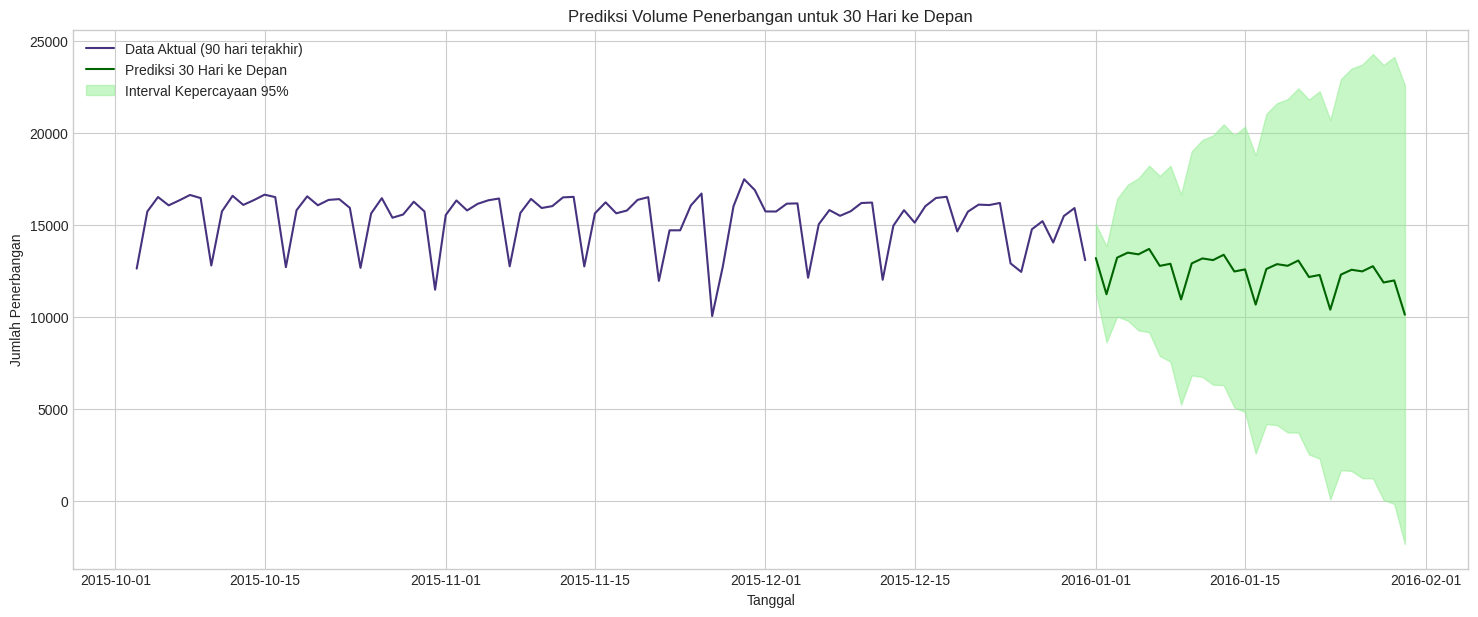


Pembersihan memori selesai. Eksekusi berakhir.


In [ ]:
if 'results_sarima' in locals() and results_sarima is not None and not daily_flights_volume_ts.empty:
    print("\n--- Prediksi Volume Penerbangan Masa Depan (Forecasting) ---")

    # Latih ulang model dengan seluruh data untuk forecasting yang lebih akurat
    full_model = SARIMAX(daily_flights_volume_ts['num_flights'], # PERBAIKAN
                         order=results_sarima.model.order,
                         seasonal_order=results_sarima.model.seasonal_order).fit()

    future_steps = 30
    forecast = full_model.get_forecast(steps=future_steps)
    forecast_values = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()

    plt.figure(figsize=(18, 7))
    plt.plot(daily_flights_volume_ts['num_flights'][-90:], label='Data Aktual (90 hari terakhir)')
    plt.plot(forecast_values, label=f'Prediksi {future_steps} Hari ke Depan', color='darkgreen')
    plt.fill_between(confidence_intervals.index,
                     confidence_intervals.iloc[:, 0],
                     confidence_intervals.iloc[:, 1],
                     color='lightgreen', alpha=0.5, label='Interval Kepercayaan 95%')
    plt.title(f'Prediksi Volume Penerbangan untuk {future_steps} Hari ke Depan')
    plt.xlabel('Tanggal'); plt.ylabel('Jumlah Penerbangan'); plt.legend()
    plt.show()

    # ... (Interpretasi untuk tiket.com sudah bagus, bisa dibiarkan seperti adanya) ...

else:
    print("Model SARIMA belum dilatih. Blok 7 dilewati.")


# --- Pembersihan Memori Terakhir ---
if 'daily_flights_volume_ts' in locals(): del daily_flights_volume_ts
if 'train_data' in locals(): del train_data
if 'test_data' in locals(): del test_data
if 'results_sarima' in locals(): del results_sarima
gc.collect()
print("\nPembersihan memori selesai. Eksekusi berakhir.")